<a href="https://colab.research.google.com/github/JamieBali/MRSCC/blob/main/ANLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [10]:
!pip install Transformers

import pandas as pd, csv
import os, random, nltk
nltk.download("wordnet")
from nltk.corpus import wordnet as wn, wordnet_ic as wn_ic, lin_thesaurus as lin
brown_ic = wn_ic.ic("ic-brown.dat")

from google.colab import drive
drive.mount('/content/gdrive')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# BERT Pre-Trained Model

The BERT pre-trained model is a bi-directional and fully-interconnected neural model that can be used for both generation and sentence completion. 

In [6]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, AdamW

from tqdm.auto import tqdm

# Load pre-trained models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def make_segment_ids(list_of_tokens):
  #this function assumes that up to and including the first '[SEP]' is the first segment, anything afterwards is the second segment
  current_id=0
  segment_ids=[]
  for token in list_of_tokens:
    segment_ids.append(current_id)
  return torch.tensor([segment_ids])

def tokeniseText(question):
  masked_index = 0 
  tokenized = ["[CLS]"] + tokenizer.tokenize(question)
  temp = []
  found = False
  for i, word in enumerate(tokenized):
    if word == "_" and found == False:
      if tokenized[i+4] == "_":
        masked_index = i
        temp.append("[MASK]")
        found = True            # this fixes the issue of underscores appearing later in the word.
    elif word == "_":
      pass
    else:
      temp.append(word)
  temp.append("[SEP]")


  segment_ids=make_segment_ids(temp)
  return torch.tensor([tokenizer.convert_tokens_to_ids(temp)]), masked_index, segment_ids

In [4]:
def predict(input_sentence):
  tokens_tensor, masked_index, segment_ids = tokeniseText(input_sentence)

  with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segment_ids)
    predictions = outputs[0]
        
  # find the token id which maximises the prediction for the masked token and then convert this back to a word
  predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
  return predicted_token

In [28]:
def getMostLikelyFromPrediction(prediction, choices):
  best_word_path = ""
  best_sim_path = 0
  best_word_res = ""
  best_sim_res = 0
  best_word_lin = ""
  best_sim_lin = 0
  for x in choices:
    highest_sim_path = 0
    highest_sim_res = 0
    highest_sim_lin = 0
    for a in wn.synsets(prediction):
      for b in wn.synsets(x):
        temp_path = None
        temp_res = None
        temp_lin = None
        try:
          temp_path = wn.path_similarity(a, b)
          temp_res = wn.res_similarity(a, b, brown_ic)
          temp_lin = wn.lin_similarity(a, b, brown_ic)
        except:
          pass
        if not temp_path == None:
          if temp_path > highest_sim_path:
            highest_sim_path = temp_path

        if not temp_res == None:
          if temp_res > highest_sim_res:
            highest_sim_res = temp_res
        
        if not temp_lin == None:
          if temp_lin > highest_sim_lin:
            highest_sim_lin = temp_lin

    if highest_sim_path > best_sim_path:
      best_word_path = x
      best_sim_path = highest_sim_path

    if highest_sim_res > best_sim_res:
      best_word_res = x
      best_sim_res = highest_sim_res

    if highest_sim_lin > best_sim_lin:
      best_word_lin = x
      best_sim_lin = highest_sim_lin




  if best_word_path == "":
    n = random.randint(0,4)
  else:
    n = choices.index(best_word_path)
  if best_word_res == "":
    o = random.randint(0,4)
  else:
    o = choices.index(best_word_res)
  if best_word_lin == "":
    p = random.randint(0,4)
  else:
    p = choices.index(best_word_lin)

  letters = ["a","b","c","d","e"]
  return letters[n], letters[o], letters[p]

In [ ]:
questions=os.path.join("/content/gdrive/My Drive/ColabNotebooks/ANLE/Resources/testing_data.csv")
answers=os.path.join("/content/gdrive/My Drive/ColabNotebooks/ANLE/Resources/test_answer.csv")
with open(questions) as instream:
  csvreader=csv.reader(instream)
  lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])
qs_df.head()
results_path = []
results_res = []
results_lin = []
for num in range(0, len(qs_df)):
  sentence = qs_df["question"][num]
  prediction = predict(sentence)
  print(prediction)
  letters = ["a)","b)","c)","d)","e)"]
  choices = []
  for x in letters:
    choices.append(qs_df[x][num])
  path, res, lin = getMostLikelyFromPrediction(prediction, choices)
  results_path.append(path)
  results_res.append(res)
  results_lin.append(lin)

with open(answers) as instream:
  csvreader=csv.reader(instream)
  lines=list(csvreader)
as_df=pd.DataFrame(lines[1:],columns=lines[0])
as_df.head()
answer_list = []
for x in as_df["answer"]:
  answer_list.append(x)

p_acc = 0
r_acc = 0
l_acc = 0
for i in range(0, len(qs_df)):
  if answer_list[i] == results_path[i]:
    p_acc += 1
  if answer_list[i] == results_res[i]:
    r_acc += 1
  if answer_list[i] == results_lin[i]:
    l_acc += 1
print("path accuracy = " + str(p_acc/len(answer_list)))
print("res accuracy  = " + str(r_acc/len(answer_list)))
print("lin accuracy  = " + str(l_acc/len(answer_list)))

# path = 43.08%
# res = 44.71%
# lin = 45.67


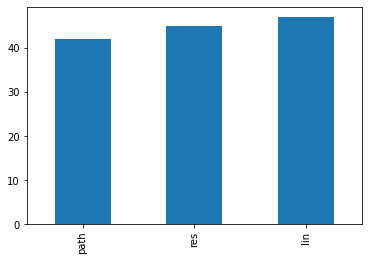

In [37]:
df = pd.DataFrame([42,45,47], index=["path","res","lin"])
df.plot.bar(legend=False)

# N-Gram Model

We will make a series of n-gram models and find an optimal accuracy using them.

In [ ]:
unigram = {}
bigram = {}
trigram = {}
quadrigram = {}

TRAINING_DIR = "/content/gdrive/My Drive/ColabNotebooks/ANLE/Resources/Holmes_Training_Data"
filenames=os.listdir(TRAINING_DIR) 
print(len(filenames))

523


 ~ ! ~  This will not run without colab pro due to the volume of the local dictionaries exceeding the 12Gb limit ~ ! ~

In [ ]:
index_of_found = []

In [ ]:
for d in range(0, len(filenames)):
  try:
    doc = filenames[d]
    print(d)
    full_doc = ""
    with open(os.path.join(TRAINING_DIR, doc)) as instream:
      for line in instream:
        full_doc += line[:-1] + " "   # by removing the last 2 characters, we remove the \n characters from the end of every line.
    full_doc = full_doc.split(" ")
    tokens = ["__END","__START"]


    # Here we tokenise the entire document so it can be easily converted into an n-gram.
    # This is not the most efficient system, but i don't know how to do regex in python.
    for token in full_doc:
      word = token
      if len(word) > 0 and not word == "\"": # This ignores blank tokens as well as tokens that contain just speech marks
        if word[-1] == "\"": # we individually remove punctuation
          word = word[:-1]
        if word[0] == "\"": 
          word = word[1:]
        if word[-1] == "." or word[-1] == "!" or word[-1] == "?": # sentence enders need tokens added to end and start new sentences
          tokens.append(word[:-1])
          tokens.append(word[-1])
          tokens.append("__END")
          tokens.append("__START")
        elif word[-1] == "," or word[-1] == ";":
          tokens.append(word[:-1])
          tokens.append(word[-1])
        elif not word == "":
          tokens.append(word)

    
    # Here we construct the n-grams, creating sums of occurances for all documents
    for i in range(len(tokens)):
      unigram[tokens[i]] = unigram.get(tokens[i], 0) + 1
      if i < len(tokens) - 1:
        if not tokens[i] in bigram:
          bigram[tokens[i]] = {}
        bigram[tokens[i]][tokens[i+1]] = bigram[tokens[i]].get(tokens[i+1], 0) + 1
      if i < len(tokens) - 2:
        if not tokens[i] in trigram:
          trigram[tokens[i]] = {}
        if not tokens[i+1] in trigram[tokens[i]]:
          trigram[tokens[i]][tokens[i+1]] = {}
        trigram[tokens[i]][tokens[i+1]][tokens[i+2]] = trigram[tokens[i]][tokens[i+1]].get(tokens[i+2], 0) + 1
      if i < len(tokens) - 3:
        if not tokens[i] in quadrigram:
          quadrigram[tokens[i]] = {}
        if not tokens[i+1] in quadrigram[tokens[i]]:
          quadrigram[tokens[i]][tokens[i+1]] = {}
        if not tokens[i+2] in quadrigram[tokens[i]][tokens[i+1]]:
          quadrigram[tokens[i]][tokens[i+1]][tokens[i+2]] = {}
        quadrigram[tokens[i]][tokens[i+1]][tokens[i+2]][tokens[i+3]] = quadrigram[tokens[i]][tokens[i+1]][tokens[i+2]].get(tokens[i+3], 0) + 1
  except:
    print("error in file " + filenames[d])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
error in file MOHIC10.TXT
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
error in file GHROS10.TXT
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
error in file LLIFE10.TXT
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257


In [ ]:
sum = 0
for x in unigram:
  sum += unigram[x]
for x in unigram:
  unigram[x] /= sum

for x in bigram:
  sum = 0
  for y in bigram[x]:
    sum += bigram[x][y]
  for y in bigram[x]:
    bigram[x][y] = bigram[x][y] / sum

for x in trigram:
  for y in trigram[x]:
    sum = 0
    for z in trigram[x][y]:
      sum += trigram[x][y][z]
    for z in trigram[x][y]:
      trigram[x][y][z] /= sum

for x in quadrigram:
  for y in quadrigram[x]:
    for z in quadrigram[x][y]:
      sum = 0
      for t in quadrigram[x][y][z]:
        sum += quadrigram[x][y][z][t]
      for t in quadrigram[x][y][z]:
        quadrigram[x][y][z][t] /= sum

In [ ]:
questions=os.path.join("/content/gdrive/My Drive/ColabNotebooks/ANLE/Resources/testing_data.csv")
answers=os.path.join("/content/gdrive/My Drive/ColabNotebooks/ANLE/Resources/test_answer.csv")
with open(questions) as instream:
  csvreader=csv.reader(instream)
  lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])
qs_df.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


In [ ]:
def get_left_context(sentence):
  sent = ["_END", "_START"] + sentence.split(" ")
  last = "_START"
  twolast = "_END"
  for i in range(2, len(sent)):
    if sent[i] == "_____":
      return sent[i-3], sent[i-2], sent[i-1]

results = []
for num in range(0, len(qs_df["question"])):
  sentence = qs_df["question"][num]
  options = []
  options.append(qs_df["a)"][num])
  options.append(qs_df["b)"][num])
  options.append(qs_df["c)"][num])
  options.append(qs_df["d)"][num])
  options.append(qs_df["e)"][num])
  guesses = []
  c1, c2, c3 = get_left_context(sentence)
  for option in options:
    try:
      guesses.append(quadrigram[c1][c2][c3][option])
    except:
      guesses.append(0)
  greater = False
  highest = 0
  res = ""
  if guesses[0] > highest:
    greater = True
    res = "a"
    highest = guesses[0]
  if guesses[1] > highest:
    greater = True
    res = "b"
    highest = guesses[1]
  if guesses[2] > highest:
    greater = True
    res = "c"
    highest = guesses[2]
  if guesses[3] > highest:
    greater = True
    res = "d"
    highest = guesses[3]
  if guesses[4] > highest:
    greater = True
    res = "e"
    highest = guesses[4]
  if greater == True:
    results.append(res)
    index_of_found.append(num)
  else:
    print("UNFOUND")
    results.append(random.choice(["a","b","c","d","e"]))

In [ ]:
with open(answers) as instream:
  csvreader=csv.reader(instream)
  lines=list(csvreader)
as_df=pd.DataFrame(lines[1:],columns=lines[0])
as_df.head()
answer_list = []
for x in as_df["answer"]:
  answer_list.append(x)

In [ ]:
sum = 0
for x in index_of_found:
  if answer_list[x] == results[x]:
    sum += 1
print(sum / len(index_of_found))

# no unfound words. 24.71% accuracy
# 31 unfound words. 26.84% accuracy
# 297 unfound words. 31.58% accuracy
# 752 unfound words. 26.06% accuracy

# quadrigram given found. 45.40% accuracy

0.45396825396825397


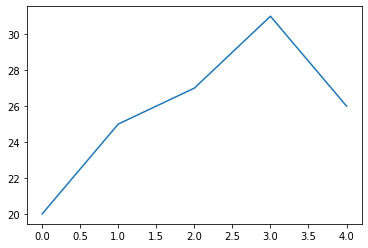

In [ ]:
df = pd.DataFrame([20,25,27,31,26], index=[0, 1, 2, 3, 4])
df.plot(legend=False)

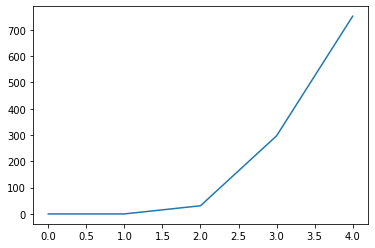

In [ ]:
df = pd.DataFrame([0, 0, 31, 297, 752])
df.plot(legend=False)